# Importing Libraries

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(10)
import warnings
warnings.filterwarnings("ignore")

#Single model classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

#Ensemble classifications models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,confusion_matrix, classification_report, roc_auc_score,
f1_score, recall_score, precision_score, SCORERS)
import time

# Imbalance, Hyperparameter tunning and pipelines
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [48]:
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

import seaborn as sns

import itertools

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report, precision_score, recall_score, accuracy_score, f1_score
# from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# from deslib.static.stacked import StackedClassifier

# from vecstack import stacking


In [3]:
from sklearn.metrics import roc_auc_score
def scores(model,X_train,X_val,y_train,y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    train = roc_auc_score(y_train,train_prob)
    val = roc_auc_score(y_val,val_prob)
    print('train:',round(train,2),'test:',round(val,2))

In [4]:
from sklearn.metrics import roc_curve
def roc_plot(model,X_train,y_train,X_val,y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    plt.figure(figsize=(7,7))
    for data in [[y_train, train_prob],[y_val, val_prob]]: # ,[y_test, test_prob]
        fpr, tpr, threshold = roc_curve(data[0], data[1])
        plt.plot(fpr, tpr)
    annot(fpr, tpr, threshold)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.ylabel('TPR (power)')
    plt.xlabel('FPR (alpha)')
    plt.legend(['train','val'])
    plt.show()

In [5]:
def opt_plots(opt_model):
    opt = pd.DataFrame(opt_model.cv_results_)
    cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
    params = pd.DataFrame(list(opt.params))
    opt = pd.concat([params,opt[cols]],axis=1,sort=False)
    
    plt.figure(figsize=[15,4])
    plt.subplot(121)
    sns.heatmap(pd.pivot_table(opt,index='max_depth',columns='min_samples_leaf',values='mean_train_score')*100)
    plt.title('ROC_AUC - Training')
    plt.subplot(122)
    sns.heatmap(pd.pivot_table(opt,index='max_depth',columns='min_samples_leaf',values='mean_test_score')*100)
    plt.title('ROC_AUC - Validation')
#     return opt

In [49]:
def baseline_models(data=[], verbose=False):
    #List of models to be used
    models=[DecisionTreeClassifier(),LogisticRegression(),
            RandomForestClassifier(),GradientBoostingClassifier()]
    #Create training and testing data sets depending on wheather or not they have been generated previously.
    if len(data)== 2:
        X_train, X_test, y_train, y_test = train_test_split(data[0],data[1],random_state=123)
    else:
        X_train, X_test, y_train, y_test = data[0],data[1],data[2],data[3]
    #Instantiate lists to store each of the models results
    accuracy = []
    f1 = []
    auc = []
    recall = []
    precision = []
    #Run thorugh each of the models to get their performance metrics
    for model in models:
        clf = model
        clf.fit(X_train, y_train)
        test_preds = clf.predict(X_test)
        f1.append(f1_score(y_test, test_preds))
        accuracy.append(accuracy_score(y_test, test_preds))
        auc.append(roc_auc_score(y_test, test_preds))
        recall.append(recall_score(y_test, test_preds))
        precision.append(precision_score(y_test, test_preds))
        scores(model,X_train,X_test, y_train,y_test)
        roc_plot(model,X_train,X_test, y_train,y_test)
        #Print the model and its report
        if verbose:
            print('Classification Model: ',model,'\n')
            print(classification_report(y_test, test_preds),'\n')
    #store results in dataframe
    results = pd.DataFrame([f1,auc, accuracy, precision,recall],
                      index= ['f1','roc_auc','accuracy','precision','recall',],
                           columns=['DecisionTree','LogisticRegression','RandomForest','Gradient Boosting'])
    #Change orientation of the dataframe
    return results.transpose()

def plot_feat_importance(clf,index):
    '''Plot the 0 most important features for a classifier model in a bar chart
    according to importance'''
    feat_importances = pd.DataFrame(clf.feature_importances_, index=index, columns=['Score'])
    feat_importances = feat_importances.sort_values(by='Score',ascending=True).tail(10)
    feat_importances.plot(kind='barh', title='Top 10 Important Features',legend=False)
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show();
    
def heatmap(data,figsize=(8,8), annot=False):
    #plot heatmap to find multicollinearity
    plt.figure(figsize=figsize)
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
    sns.heatmap(data.corr(),vmin=-0.75,vmax=0.75,center=0, cmap=cmap,annot=annot);

def grid_pipe(pipedict, hyperdict, scoring='accuracy', display=True):
    model_scores=[]
    fitted_models={}
    for name, pipeline in pipedict.items():
    # Construct grid search
        model = GridSearchCV(estimator=pipeline,
                             param_grid=hyperdict[name],
                             scoring=scoring,
                             cv=5, verbose=2, n_jobs=-1, return_train_score = True)

        # Fit using grid search
        start = time.time()
        model.fit(X_trainres, y_trainres)
        end = time.time()
        #Append socres and time
        model_scores.append((name,model.best_score_,end-start))
        #Append model
        fitted_models[name]=model
        if display:
            #Print when the model has been fitted
            print(f'The {name} model has been fitted.')
            # Best accuracy
            print('Best accuracy: %.3f' % model.best_score_)
            # Best params
            print('Best params:\n', model.best_params_,'\n')
    
    return model_scores, fitted_models

In [7]:
from sklearn.metrics import roc_auc_score
def scores(model,X_train,X_val,y_train,y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    train = roc_auc_score(y_train,train_prob)
    val = roc_auc_score(y_val,val_prob)
    print('train:',round(train,2),'test:',round(val,2))

In [8]:
from sklearn.metrics import roc_curve
def roc_plot(model,X_train,y_train,X_val,y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    plt.figure(figsize=(7,7))
    for data in [[y_train, train_prob],[y_val, val_prob]]: # ,[y_test, test_prob]
        fpr, tpr, threshold = roc_curve(data[0], data[1])
        plt.plot(fpr, tpr)
    annot(fpr, tpr, threshold)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.ylabel('TPR (power)')
    plt.xlabel('FPR (alpha)')
    plt.legend(['train','val'])
    plt.show()

In [9]:
from sklearn.metrics import roc_auc_score
def scores(model,X_train,X_val,y_train,y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    train = roc_auc_score(y_train,train_prob)
    val = roc_auc_score(y_val,val_prob)
    print('train:',round(train,2),'test:',round(val,2))

In [10]:
def annot(fpr,tpr,thr):
    k=0
    for i,j in zip(fpr,tpr):
        if k %50 == 0:
            plt.annotate(round(thr[k],2),xy=(i,j), textcoords='data')
        k+=1

In [11]:
from sklearn.metrics import roc_curve
def roc_plot(model,X_train,y_train,X_val,y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    plt.figure(figsize=(7,7))
    for data in [[y_train, train_prob],[y_val, val_prob]]: # ,[y_test, test_prob]
        fpr, tpr, threshold = roc_curve(data[0], data[1])
        plt.plot(fpr, tpr)
    annot(fpr, tpr, threshold)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.ylabel('TPR (power)')
    plt.xlabel('FPR (alpha)')
    plt.legend(['train','val'])
    plt.show()

In [12]:
def opt_plots(opt_model):
    opt = pd.DataFrame(opt_model.cv_results_)
    cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
    params = pd.DataFrame(list(opt.params))
    opt = pd.concat([params,opt[cols]],axis=1,sort=False)
    
    plt.figure(figsize=[15,4])
    plt.subplot(121)
    sns.heatmap(pd.pivot_table(opt,index='max_depth',columns='min_samples_leaf',values='mean_train_score')*100)
    plt.title('ROC_AUC - Training')
    plt.subplot(122)
    sns.heatmap(pd.pivot_table(opt,index='max_depth',columns='min_samples_leaf',values='mean_test_score')*100)
    plt.title('ROC_AUC - Validation')
#     return opt

# Uploading Data

In [13]:
raw_df = pd.read_csv('online_shoppers_intention.csv')

In [14]:
raw_df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [15]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
Administrative             12330 non-null int64
Administrative_Duration    12330 non-null float64
Informational              12330 non-null int64
Informational_Duration     12330 non-null float64
ProductRelated             12330 non-null int64
ProductRelated_Duration    12330 non-null float64
BounceRates                12330 non-null float64
ExitRates                  12330 non-null float64
PageValues                 12330 non-null float64
SpecialDay                 12330 non-null float64
Month                      12330 non-null object
OperatingSystems           12330 non-null int64
Browser                    12330 non-null int64
Region                     12330 non-null int64
TrafficType                12330 non-null int64
VisitorType                12330 non-null object
Weekend                    12330 non-null bool
Revenue                    12330 non-null bool
dtypes: bool(

# Missing Values 

In [16]:
raw_df.isna().any()

Administrative             False
Administrative_Duration    False
Informational              False
Informational_Duration     False
ProductRelated             False
ProductRelated_Duration    False
BounceRates                False
ExitRates                  False
PageValues                 False
SpecialDay                 False
Month                      False
OperatingSystems           False
Browser                    False
Region                     False
TrafficType                False
VisitorType                False
Weekend                    False
Revenue                    False
dtype: bool

In [17]:
raw_df.head().iloc[:,:9]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0


In [18]:
raw_df.head().iloc[:,9:]

,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [19]:
raw_df.describe().iloc[:,:8]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157213,0.016813,0.050000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000


In [20]:
raw_df.describe().iloc[:,8:]

,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


# EDA 

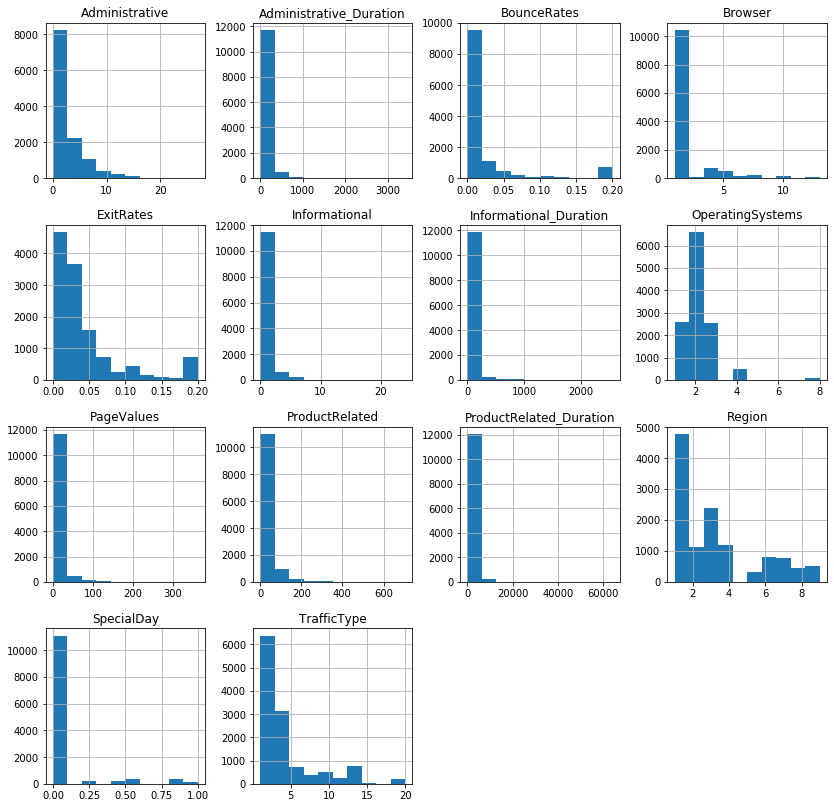

In [21]:
raw_df[raw_df.describe().columns].hist(figsize=(14,14));

In [22]:
raw_df.SpecialDay.value_counts()

0.0    11079
0.6      351
0.8      325
0.4      243
0.2      178
1.0      154
Name: SpecialDay, dtype: int64

 Special Day is a categorical variable as it has 6 specific values 

# Screen for non-numerical features 

In [23]:
non_num_cols = list(set(raw_df.columns) - set(raw_df.describe().columns))
print('Non-numerical features: ',non_num_cols)

Non-numerical features:  ['VisitorType', 'Revenue', 'Month', 'Weekend']


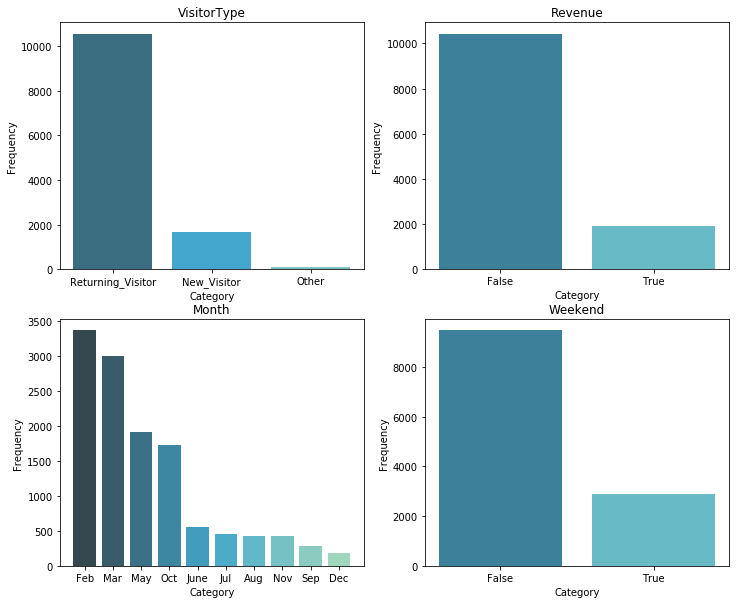

In [24]:
fig, axs = plt.subplots(2, 2,figsize=(12,10))
#Create a bar chart for each of the non-numerical variables.
for i, col in enumerate(non_num_cols):
    #Helper variables to assign the correct axes to each of the 4 plots.
    j=i//2
    k=i%2
    #Setting a color palette for the plots.
    color = sns.color_palette("GnBu_d",n_colors=len(raw_df[col].unique()))
    #Create the bar plot.
    axs[j,k].bar(raw_df[col].astype('str').unique(), raw_df[col].value_counts(), color= color)
    axs[j,k].set_title(col)
    axs[j,k].set_ylabel('Frequency')
    axs[j,k].set_xlabel('Category')
plt.show();

In [25]:
print(raw_df.VisitorType.value_counts(),'\n')
print('''Number of revenue generating users as VisitorType 'Other': ''',
      raw_df[raw_df['VisitorType']=='Other'][raw_df['Revenue']==True].Revenue.count())

Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64 

Number of revenue generating users as VisitorType 'Other':  16


#
1. False(value:0) - The session did not generate sales  
2. True(value:1) - The session did generate sales 

False    84.53
True     15.47
Name: Revenue, dtype: float64


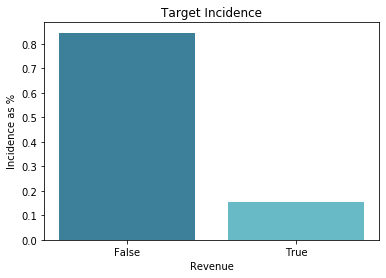

In [26]:
print(round(raw_df.Revenue.value_counts(normalize=True),4)*100)
plt.bar(['False','True'], raw_df.Revenue.value_counts(normalize=True), color=sns.color_palette("GnBu_d",n_colors=2))
plt.title('Target Incidence')
plt.ylabel('Incidence as %')
plt.xlabel('Revenue')
plt.show();

1    38.77
3    19.49
4     9.59
2     9.21
6     6.53
7     6.17
9     4.14
8     3.52
5     2.58
Name: Region, dtype: float64


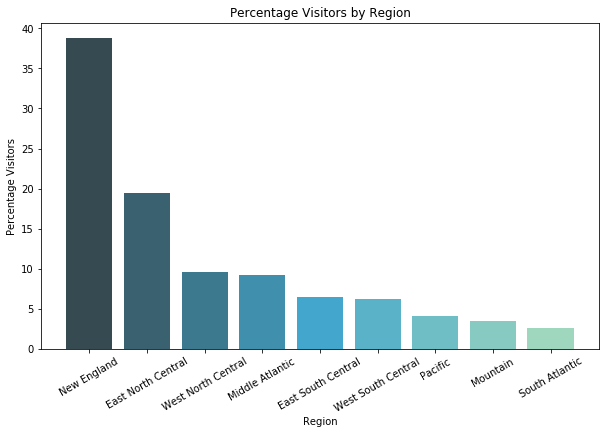

In [27]:
regional_revenue = raw_df[['Region','Revenue']]
regional_revenue = regional_revenue.replace(to_replace=[1, 2,3,4,5,
                                                        6,7,8,9],value=['New England','Middle Atlantic',
                                                                        'East North Central',
                                                                        'West North Central','South Atlantic',
                                                                        'East South Central',
                                                                        'West South Central',
                                                                        'Mountain','Pacific'])
print(round(raw_df.Region.value_counts(normalize=True),4)*100)
plt.figure(figsize=(10,6))
plt.bar(regional_revenue['Region'].value_counts(normalize=True).index, regional_revenue['Region'].value_counts(normalize=True)*100,
        color=sns.color_palette("GnBu_d",n_colors=9))
plt.xticks(rotation='30')
plt.xlabel('Region')
plt.ylabel('Percentage Visitors')
plt.title('Percentage Visitors by Region')
plt.show()

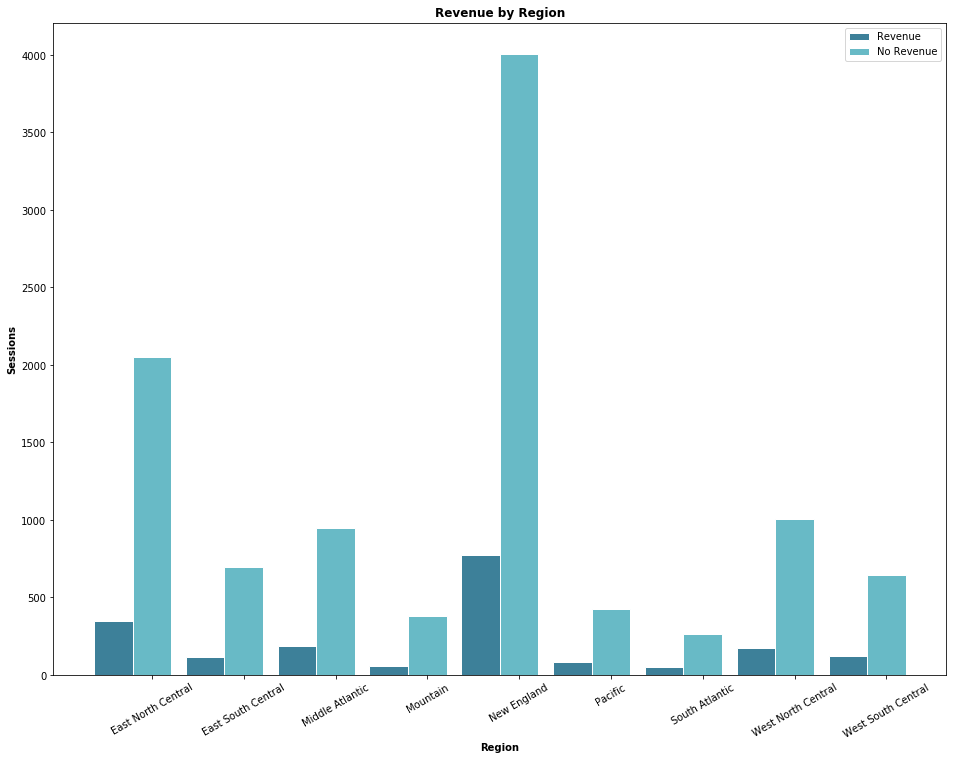

In [28]:
plt.figure(figsize=(16,12))
# set width of bar
barWidth = 0.42
 
# set height of bar
bars1 = regional_revenue[raw_df['Revenue']==True].groupby(['Region']).Revenue.count()
bars2 = regional_revenue[raw_df['Revenue']==False].groupby(['Region']).Revenue.count()
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color=sns.color_palette("GnBu_d",n_colors=2)[0],
        width=barWidth, edgecolor='white', label='Revenue')
plt.bar(r2, bars2, color=sns.color_palette("GnBu_d",n_colors=2)[1],
        width=barWidth, edgecolor='white', label='No Revenue')
 
# Add xticks on the middle of the group bars
plt.xlabel('Region', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))],
           regional_revenue[raw_df['Revenue']==True].groupby(['Region']).Revenue.count().index)
plt.xticks(rotation='30')
plt.ylabel('Sessions', fontweight='bold')
plt.title('Revenue by Region', fontweight='bold')
# Create legend & Show graphic
plt.legend()
plt.show()

In [29]:
regional_revenue.groupby(['Region']).Revenue.count()

Region
East North Central    2403
East South Central     805
Middle Atlantic       1136
Mountain               434
New England           4780
Pacific                511
South Atlantic         318
West North Central    1182
West South Central     761
Name: Revenue, dtype: int64

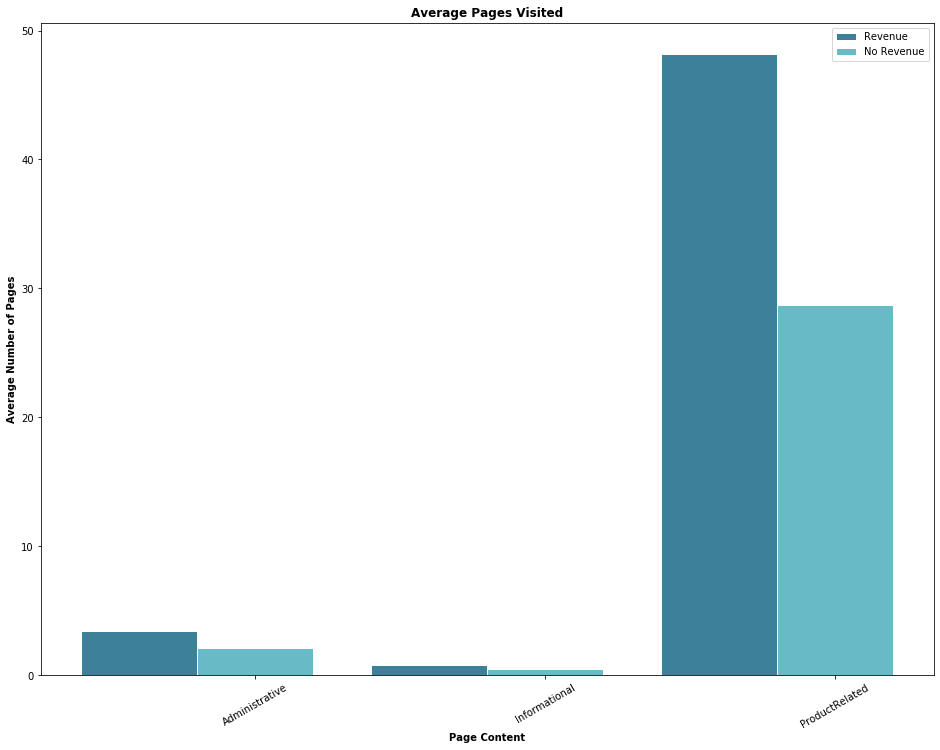

In [30]:
pages = raw_df[['Administrative','Informational', 'ProductRelated','Revenue']].groupby('Revenue').mean()
plt.figure(figsize=(16,12))
# set width of bar
barWidth = 0.40
 
# set height of bar
bars1 = pages.iloc[1]
bars2 = pages.iloc[0]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color=sns.color_palette("GnBu_d",n_colors=2)[0],
        width=barWidth, edgecolor='white', label='Revenue')
plt.bar(r2, bars2, color=sns.color_palette("GnBu_d",n_colors=2)[1],
        width=barWidth, edgecolor='white', label='No Revenue')
 
# Add xticks on the middle of the group bars
plt.xlabel('Page Content', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))],
           pages.iloc[0].index)
plt.xticks(rotation='30')
plt.ylabel('Average Number of Pages', fontweight='bold')
plt.title('Average Pages Visited', fontweight='bold')
# Create legend & Show graphic
plt.legend()
plt.show()

In [31]:
# removing the 'Other' category from 'VisitorType'
PCA_df = raw_df.set_index('VisitorType')
PCA_df = PCA_df.drop(['Other'], axis=0)
PCA_df = PCA_df.reset_index()
print(PCA_df['VisitorType'].value_counts())

raw_df_vt = pd.get_dummies(PCA_df['VisitorType'])
PCA_df = PCA_df.merge(raw_df_vt, left_index = True, right_index=True)

raw_df_w = pd.get_dummies(PCA_df['Weekend'])
PCA_df = PCA_df.merge(raw_df_w, left_index = True, right_index=True)

raw_df_r = pd.get_dummies(PCA_df['Revenue'])
PCA_df = PCA_df.merge(raw_df_r, left_index = True, right_index=True)

PCA_df = PCA_df.drop(['VisitorType', 'Returning_Visitor', 'Weekend', 'Revenue', 'False_x', 'False_y'], axis=1)
PCA_df = PCA_df.rename(columns={"True_x": "Weekend", "True_y": "Revenue"})

month = {'Feb':2, 'Mar':3, 'May':5, 'Oct':10, 
         'June':6, 'Jul':7, 'Aug':8, 'Nov':11, 
         'Sep':9, 'Dec':12}
PCA_df.Month = [month[item] for item in PCA_df.Month]

Returning_Visitor    10551
New_Visitor           1694
Name: VisitorType, dtype: int64


In [32]:
PCA_df

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,New_Visitor,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,2,1,1,1,1,0,0,0
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,2,2,2,1,2,0,0,0
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,2,4,1,9,3,0,0,0
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,2,3,2,2,4,0,0,0
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,2,3,3,1,4,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12240,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,12,4,6,1,1,0,1,0
12241,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,11,3,2,1,8,0,1,0
12242,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,11,3,2,1,13,0,1,0
12243,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,11,2,2,3,11,0,0,0


# Feature Engineering 

 1. OneHotEncoding

In [33]:
#Create list with categorical features' names.
nonum_feats_names = ['Month', 'OperatingSystems', 'Region', 'Revenue', 
      'SpecialDay', 'TrafficType', 'New_Visitor', 'Weekend']

#Create list with numerical features' names.
num_cols_names = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 
            'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates','PageValues']

In [34]:
#Assign appropriate data type to categorical variables.
nonum_feats = PCA_df[nonum_feats_names].astype('category')
nonum_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12245 entries, 0 to 12244
Data columns (total 8 columns):
Month               12245 non-null category
OperatingSystems    12245 non-null category
Region              12245 non-null category
Revenue             12245 non-null category
SpecialDay          12245 non-null category
TrafficType         12245 non-null category
New_Visitor         12245 non-null category
Weekend             12245 non-null category
dtypes: category(8)
memory usage: 98.2 KB


In [35]:
#One-hot-code categorical variables and dropping the reference value.
ohc_feats = pd.get_dummies(nonum_feats,drop_first=True)
ohc_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12245 entries, 0 to 12244
Data columns (total 51 columns):
Month_3               12245 non-null uint8
Month_5               12245 non-null uint8
Month_6               12245 non-null uint8
Month_7               12245 non-null uint8
Month_8               12245 non-null uint8
Month_9               12245 non-null uint8
Month_10              12245 non-null uint8
Month_11              12245 non-null uint8
Month_12              12245 non-null uint8
OperatingSystems_2    12245 non-null uint8
OperatingSystems_3    12245 non-null uint8
OperatingSystems_4    12245 non-null uint8
OperatingSystems_5    12245 non-null uint8
OperatingSystems_6    12245 non-null uint8
OperatingSystems_7    12245 non-null uint8
OperatingSystems_8    12245 non-null uint8
Region_2              12245 non-null uint8
Region_3              12245 non-null uint8
Region_4              12245 non-null uint8
Region_5              12245 non-null uint8
Region_6              12245 non

# Feature Distribution 

In [36]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(3,3,figsize=(22,26))

    for feature in features:
        i += 1
        plt.subplot(3,3,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();


<Figure size 432x288 with 0 Axes>

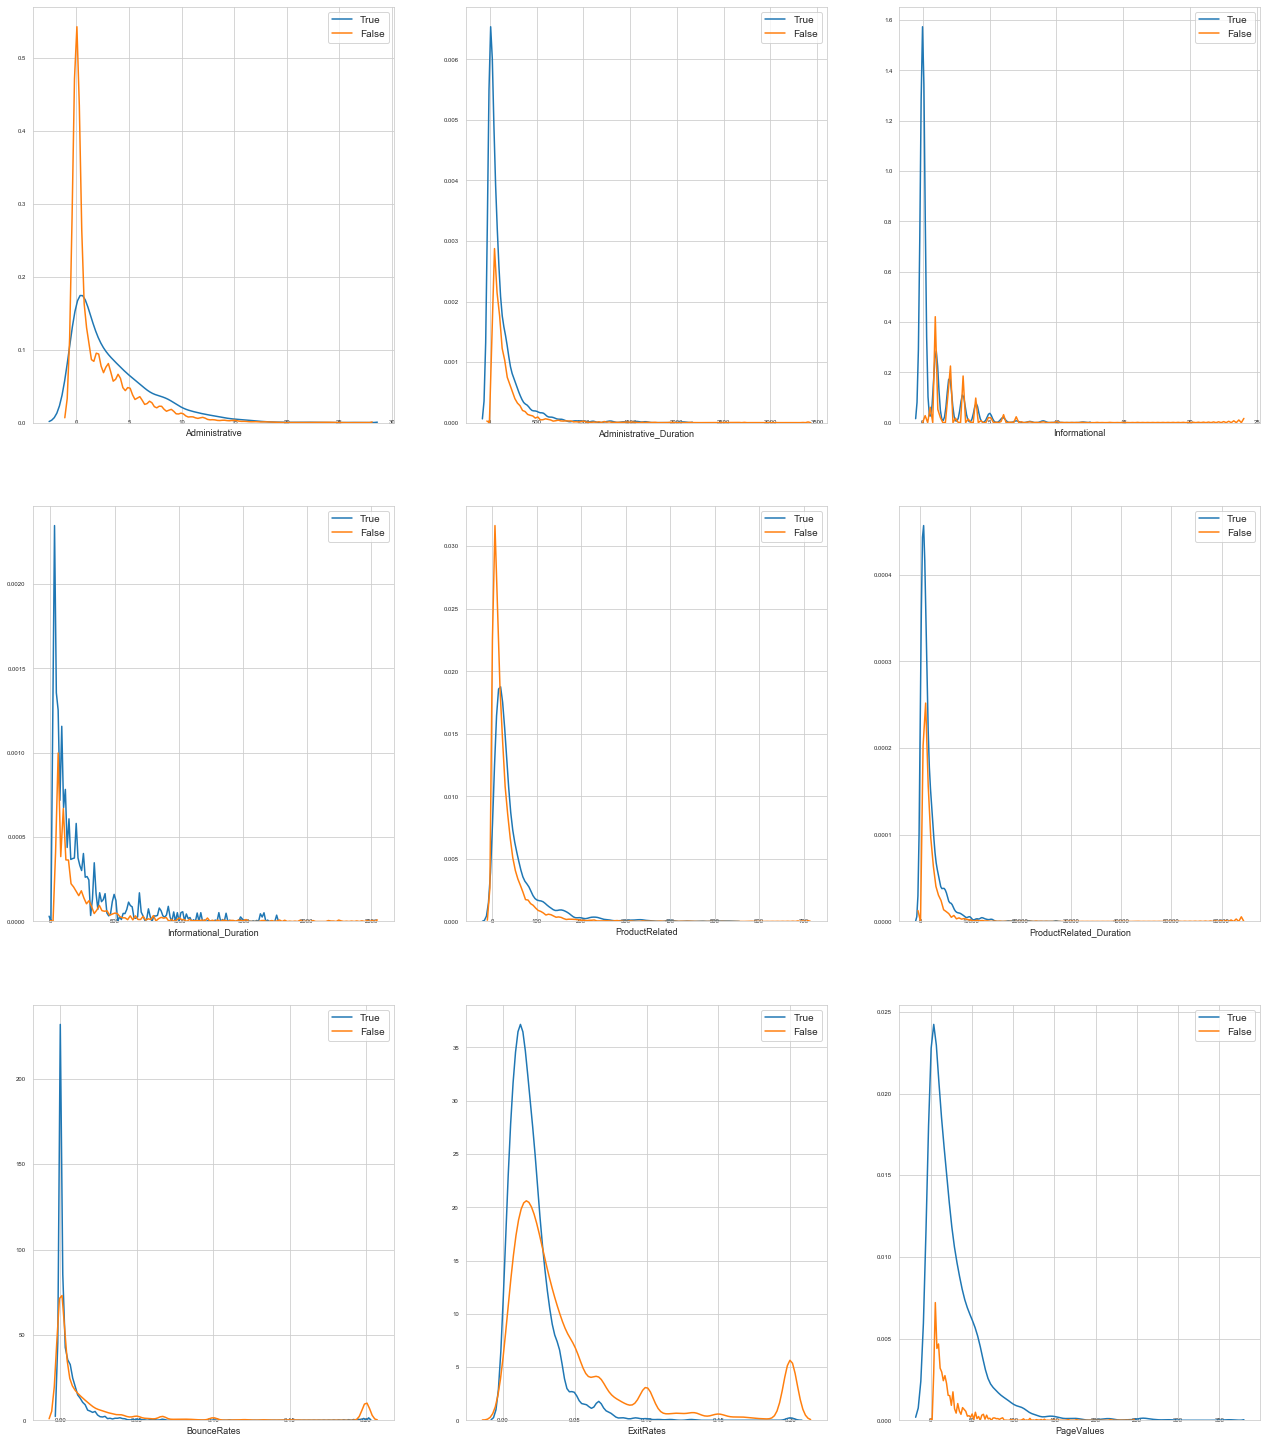

In [37]:
 t0 = PCA_df.loc[PCA_df['Revenue'] == True]
 t1 = PCA_df.loc[PCA_df['Revenue'] == False]
features = PCA_df.columns.values[0:9]
plot_feature_distribution(t0, t1, 'True', 'False', features)

# SMOTE

In [38]:
y = PCA_df['Revenue']
X = PCA_df[['Administrative','Administrative_Duration',
        'Informational', 'Informational_Duration',
        'ProductRelated', 'ProductRelated_Duration',
        'BounceRates', 'ExitRates','PageValues',
        'SpecialDay','Month','OperatingSystems','Browser',
        'Region', 'TrafficType', 'Weekend']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

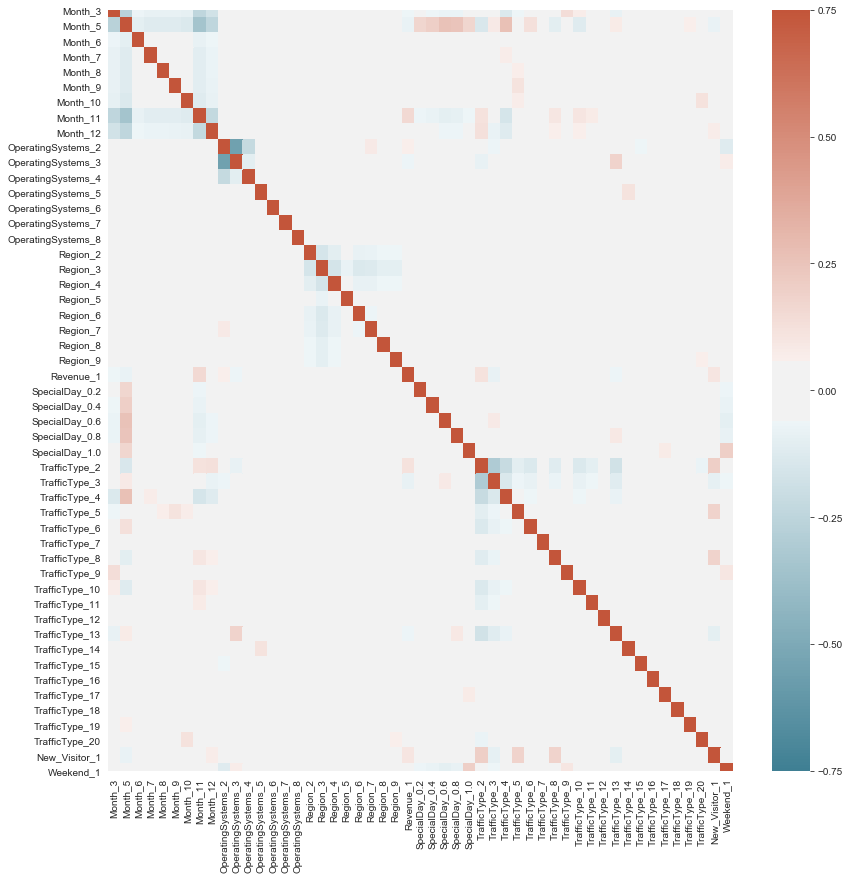

In [39]:
heatmap(ohc_feats,figsize=(14,14))

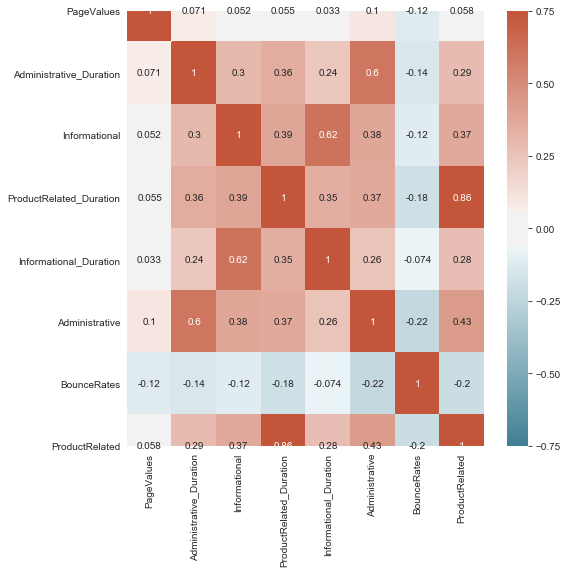

In [40]:
#ohc_data.drop('ExitRates',axis=1,inplace=True)
num_cols_names = list(set(num_cols_names)-set(['ExitRates']))
heatmap(PCA_df[num_cols_names],figsize=(8,8), annot=True);


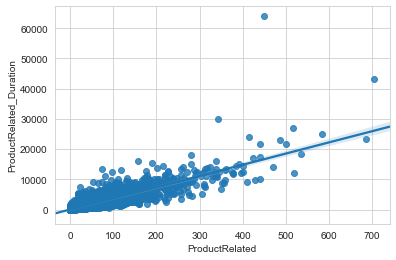

In [41]:
sns.regplot(PCA_df.ProductRelated, PCA_df.ProductRelated_Duration);

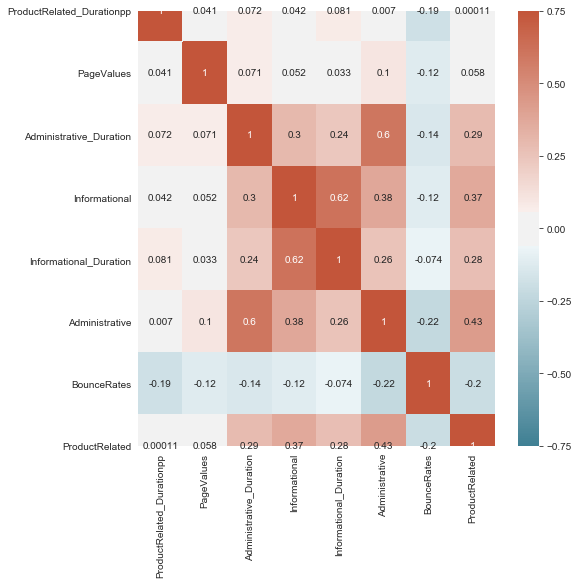

In [42]:
PCA_df['ProductRelated_Durationpp'] = PCA_df.ProductRelated_Duration/PCA_df.ProductRelated
PCA_df = PCA_df.drop('ProductRelated_Duration',axis=1)
PCA_df.ProductRelated_Durationpp.fillna(0,inplace=True)
num_cols_names.append('ProductRelated_Durationpp')
num_cols_names = list(set(num_cols_names)-set(['ProductRelated_Duration']))
heatmap(PCA_df[num_cols_names],figsize=(8,8), annot=True);

In [43]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
print(f"X_train: {X_train.shape} | X_val: {X_val.shape} | y_train {y_train.shape} | y_val {y_val.shape}")

X_train: (6428, 16) | X_val: (2755, 16) | y_train (6428,) | y_val (2755,)


In [44]:
def annot(fpr,tpr,thr):
    k=0
    for i,j in zip(fpr,tpr):
        if k %50 == 0:
            plt.annotate(round(thr[k],2),xy=(i,j), textcoords='data')
        k+=1

# Logistic Regression 

1    5427
0    5427
Name: Revenue, dtype: int64


1    5427
0    5427
Name: Revenue, dtype: int64


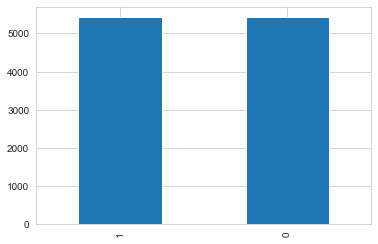

In [71]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 33)

# Previous original class distribution
print(y_train.value_counts()) 

# Fit SMOTE to training data
X_train, y_train = SMOTE().fit_sample(X_train, y_train) 

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train).value_counts()) 

# observe that data has been balanced
pd.Series(y_train).value_counts().plot.bar()

train: 0.91 test: 0.86


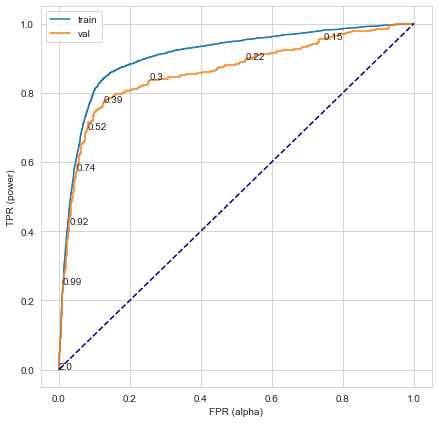

In [61]:
model_log = LogisticRegression() 
model_log.fit(X_train, y_train) 
scores(model_log,X_train,X_val,y_train,y_val) 
roc_plot(model_log,X_train,y_train,X_val,y_val)

model_log = LogisticRegression() 
model_log.fit(X_train, y_train)
scores(model_log,X_train,X_val,y_train,y_val)
roc_plot(mode_logl,X_train,y_train,X_val,y_val)

# Grid Search 

In [62]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold
skf = StratifiedKFold(n_splits=5,random_state=42)

train: 0.97 test: 0.92
{'max_depth': 10, 'min_samples_leaf': 50}
Wall time: 3.59 s


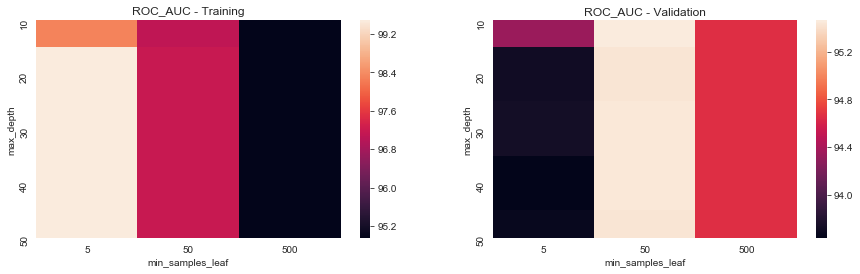

In [65]:
%%time
param_grid = {'max_depth':range(10,50+1,10),'min_samples_leaf':[5,50,500]}
model_tree = DecisionTreeClassifier()
opt_model = GridSearchCV(model_tree,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.97 test: 0.92


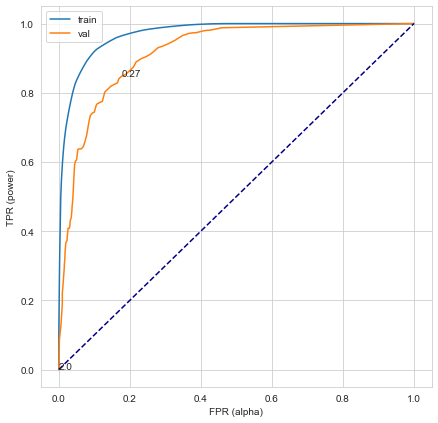

KeyError: "['ProductRelated_Duration'] not in index"

In [69]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)
y = PCA_df['Revenue']
X = PCA_df[['Administrative','Administrative_Duration',
        'Informational', 'Informational_Duration',
        'ProductRelated', 'ProductRelated_Duration',
        'BounceRates', 'ExitRates','PageValues',
        'SpecialDay','Month','OperatingSystems','Browser',
        'Region', 'TrafficType', 'Weekend']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

train: 0.98 test: 0.91
{'max_depth': 25, 'min_samples_leaf': 30}
Wall time: 6.68 s


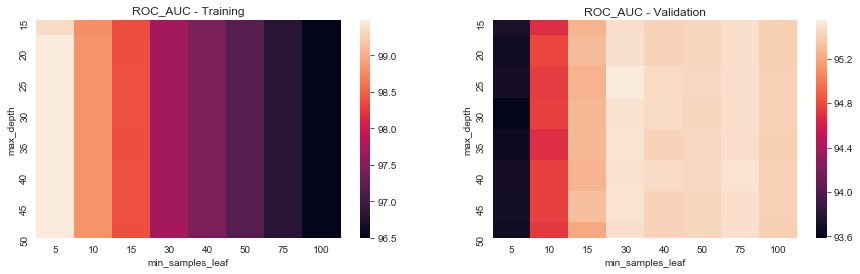

In [73]:
%%time
param_grid = {'max_depth':range(15,50+1,5),'min_samples_leaf':[5,10,15,30,40,50,75,100]}

opt_model = GridSearchCV(model_tree,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_


scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.98 test: 0.91


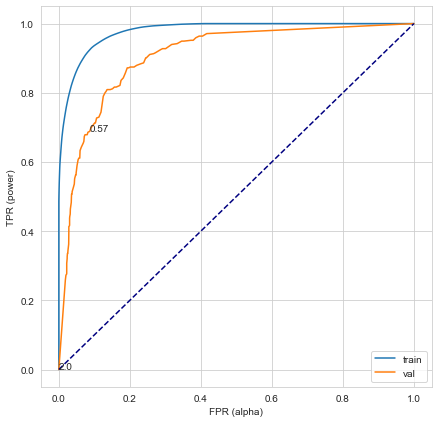

In [74]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

In [76]:
%%time
param_grid = {'max_depth':range(15,25+1),'min_~samples_leaf':range(5,30, 5)}

opt_model = GridSearchCV(model_tree,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

ValueError: Invalid parameter min_~samples_leaf for estimator DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=15, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'). Check the list of available parameters with `estimator.get_params().keys()`.

train: 0.98 test: 0.91


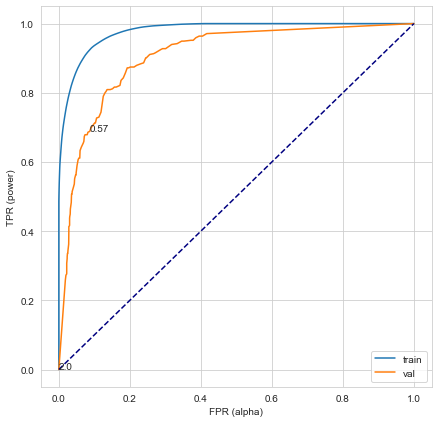

In [77]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

In [78]:
best_tree = best_model

# Random Forest

In [79]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10,n_jobs=-1,random_state=42)
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

train: 1.0 test: 0.9


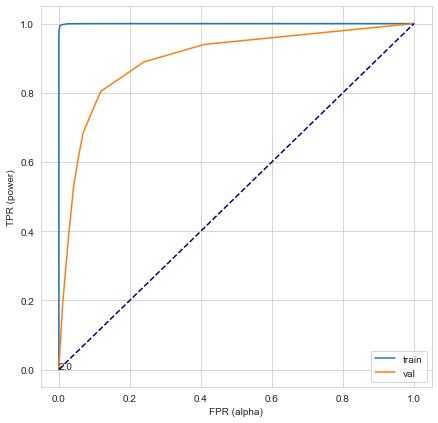

In [80]:
scores(model,X_train,X_val,y_train,y_val)
roc_plot(model,X_train,y_train,X_val,y_val)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:    6.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    6.3s finished


train: 0.99 test: 0.92
{'max_depth': 21, 'min_samples_leaf': 5}
Wall time: 6.87 s


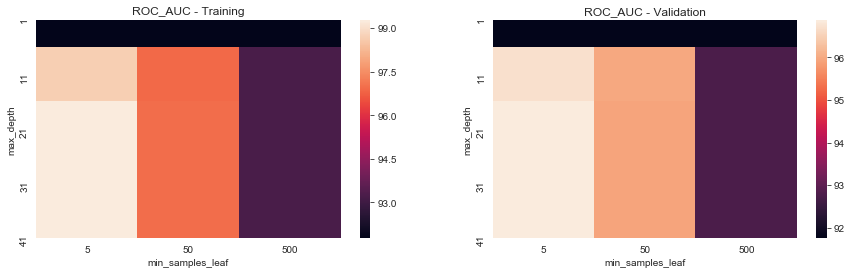

In [81]:
%%time
param_grid = {'max_depth':range(1,50+1,10),'min_samples_leaf':[5,50,500]}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1,verbose=10)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.99 test: 0.92


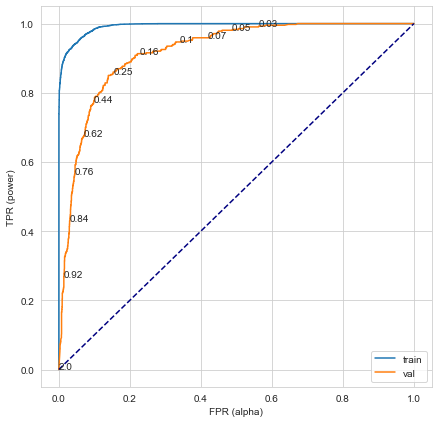

In [82]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

train: 0.99 test: 0.92


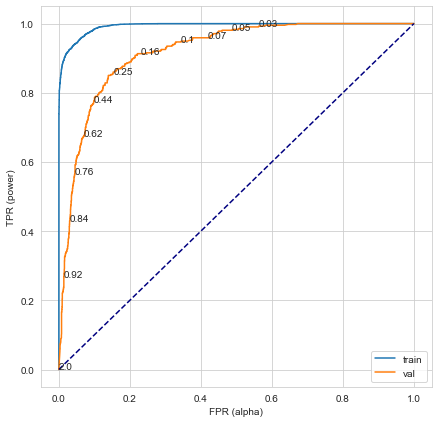

In [83]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)


train: 0.99 test: 0.92
{'max_depth': 40, 'min_samples_leaf': 5}
Wall time: 14.6 s


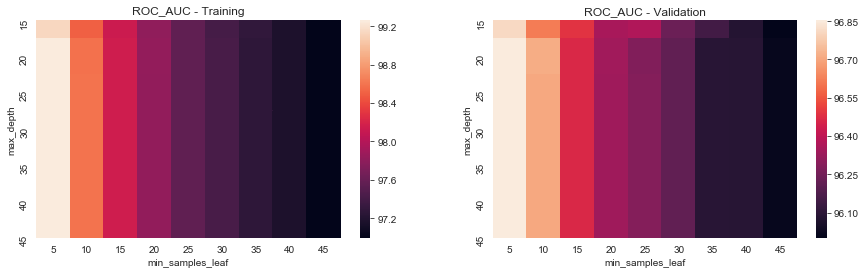

In [84]:
%%time
param_grid = {'max_depth':range(15,45+1,5),'min_samples_leaf':range(5,45+1,5)}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.99 test: 0.92


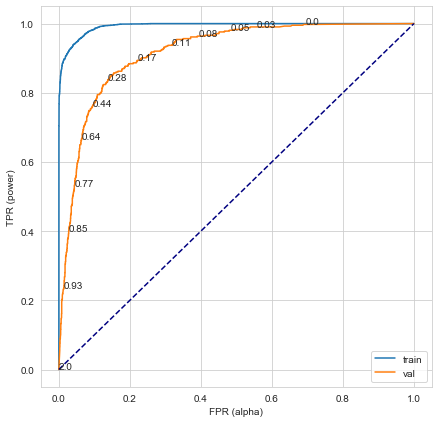

In [85]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

train: 0.99 test: 0.92


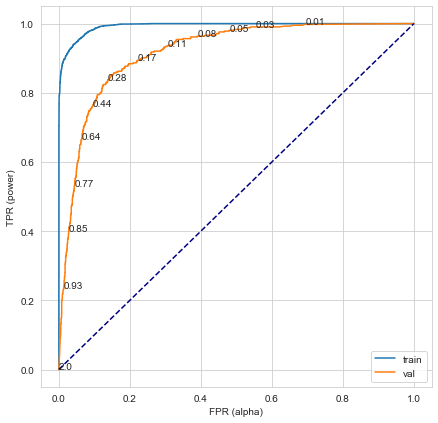

In [86]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

train: 1.0 test: 0.91
{'max_depth': 19, 'min_samples_leaf': 3}
Wall time: 15.1 s


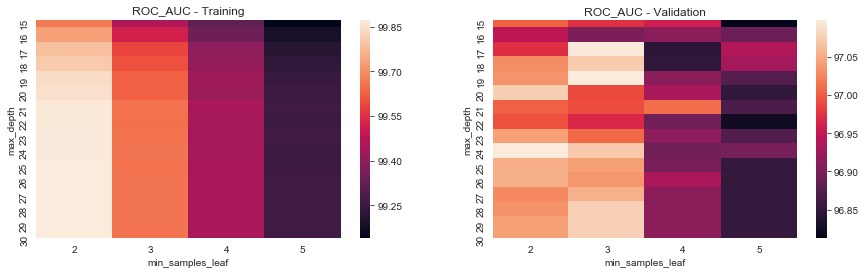

In [87]:
%%time
param_grid = {'max_depth':range(15,30+1),'min_samples_leaf':range(2,5+1)}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

In [89]:
best_forest = best_model

# AdaBoost

In [91]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(DecisionTreeClassifier(),random_state=42)
model.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                       

train: 1.0 test: 0.78


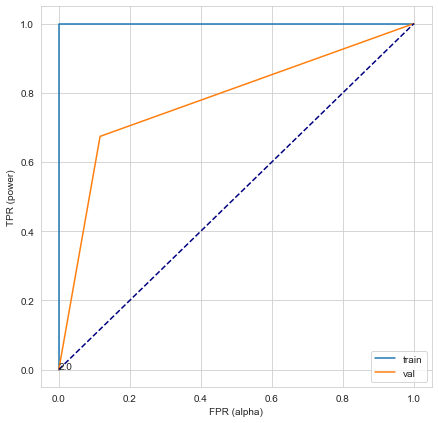

In [92]:
scores(model,X_train,X_val,y_train,y_val)
roc_plot(model,X_train,y_train,X_val,y_val)

# Grid Search - Ada Boost 


In [93]:
param_grid = {'learning_rate':[lr/100 for lr in range(1,100+1)]}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
# opt_plots(opt_model)

train: 1.0 test: 0.78
{'learning_rate': 0.01}


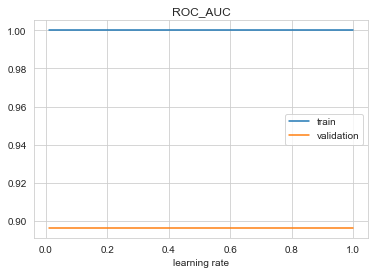

In [94]:
opt = pd.DataFrame(opt_model.cv_results_)
cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
params = pd.DataFrame(list(opt.params))
opt = pd.concat([params,opt[cols]],axis=1,sort=False)
plt.plot(opt['learning_rate'],opt['mean_train_score'])
plt.plot(opt['learning_rate'],opt['mean_test_score'])
plt.title('ROC_AUC')
plt.xlabel('learning rate')
plt.legend(['train','validation'])

In [95]:
param_grid = {'learning_rate':[lr for lr in range(1,10+1)]}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
# opt_plots(opt_model)

train: 1.0 test: 0.78
{'learning_rate': 1}


In [97]:
opt = pd.DataFrame(opt_model.cv_results_)
cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
params = pd.DataFrame(list(opt.params))
opt = pd.concat([params,opt[cols]],axis=1,sort=False)
plt.plot(opt['learning_rate'],opt['mean_train_score'])
plt.plot(opt['learning_rate'],opt['mean_test_score'])
plt.title('ROC_AUC')model_log = LogisticRegression() model_log.fit(X_Train, y_train) scores(model_log,X_train,X_val,y_train,y_val) roc_plot(mode_logl,X_train,y_train,X_val,y_val)

plt.xlabel('learning rate')
plt.legend(['train','validation'])

SyntaxError: invalid syntax (<ipython-input-97-0747086c92de>, line 7)

In [98]:
print(type(X_train))
print(type(X_val))
print(type(y_train))model_log = LogisticRegression() model_log.fit(X_train, y_train) scores(model_log,X_train,X_val,y_train,y_val) roc_plot(mode_logl,X_train,y_train,X_val,y_val)
model_log = LogisticRegression() model_log.fit(X_train, y_train) scores(model_log,X_train,X_val,y_train,y_val) roc_plot(mode_logl,X_train,y_train,X_val,y_val)
model_log = LogisticRegression() model_log.fit(X_train, y_train) scores(model_log,X_train,X_val,y_train,y_val) roc_plot(mode_logl,X_train,y_train,X_val,y_val)

print(type(y_val))

SyntaxError: invalid syntax (<ipython-input-98-9037c6fd9512>, line 3)

In [99]:
X_val = X_val.values
y_val = y_val.values
print(type(X_val))
print(type(y_val))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


train: 1.0 test: 0.78


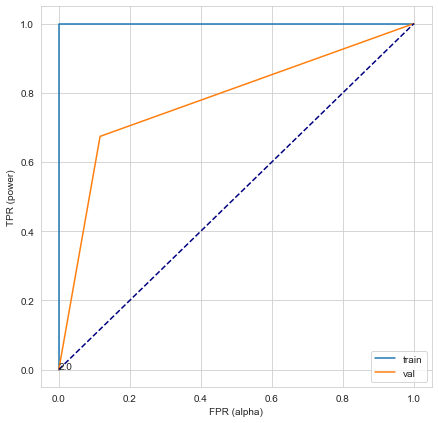

In [100]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

In [101]:
best_adaboost = best_model

# Feature Importances

In [102]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Data Shapes:")
print(f"X_train: {X_train.shape} | X_test: {X_test.shape} | y_train {y_train.shape} | y_test {y_test.shape}")

Data Shapes:
X_train: (8571, 16) | X_test: (3674, 16) | y_train (8571,) | y_test (3674,)


In [103]:

best_adaboost.estimator_weights_

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Threshold Selection 

In [ ]:
prevalence = df['Revenue'].sum()/df.shape[0]
# CALCULATE REVENUE COEFICIENT 
Revenue_coef = 
NO_Revenue_coef = 

In [ ]:
def threshold_selection(prevalence, CostFP_minus_CostTN, CostFN_minus_CostTP, y, y_hat):
    """Calculate the optimal treshold depending on prevalence, costs, true positive rate and false positive rate
    Args:
        prevalence (float): The percentage of positives in the population
        CostFP_minus_CostTN (float): [description]
        CostFN_minus_CostTP (float): [description]
        y (list): True labels (classes)
        y_hat (list): Predicted labels (classes)
    Returns:
        [float]: Best threshold
    """
    fpr, tpr, thresholds = roc_curve(y, y_hat)
    m = ((1 - prevalence) / prevalence) * ((CostFP_minus_CostTN) / (CostFN_minus_CostTP))
    fm_thresholds = []
    for i in range(len(fpr)):
        fm = tpr[i] - (m * fpr[i])
        fm_thresholds.append((thresholds[i], fm))
    fm_thresholds = sorted(fm_thresholds, key=lambda fm_value: fm_value[1], reverse=True)
    return fm_thresholds[0][0]

In [ ]:
threshold_opt=threshold_selection(prevalence, Revenue_coef, NO_Revenue_coef, y_val, y_prob[:,1])
threshold_opt

In [ ]:
y_prob_adj = y_threshed_adj(y_prob, threshold_opt)

In [ ]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(y_val, y_prob[:,1])

In [ ]:
confusion_matrix(y_val, y_prob_adj_new)

In [ ]:
functions.scores(y_val,y_prob_adj);

# Random Forest - Final Model 

In [ ]:
# Initial Model
r_for = RandomForestClassifier(random_state=0)
r_for.fit(X_train, y_train)

# Probability scores for test set
y_pred = r_for.predict(X_test)
# False positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC
print('AUC: {}'.format(auc(fpr, tpr)))

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()